<a href="https://colab.research.google.com/github/raulpoppiel/geemap/blob/master/notebooks/04_Sr_DSM_tier1_midAccuracy/1_Sr_DSM_tier1_pipeline_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img src="https://static.wixstatic.com/media/0825c5_c588e0ffa1a44017b74a83a0cfca5598~mv2.png/v1/fill/w_251,h_47,al_c,q_85,usm_0.66_1.00_0.01,enc_auto/Neutral_Farming_Logo_light.png" height="70"></center>

**"Sr digital soil mapping - Level 1 - mid accuracy"**

---



_Tool created by **Raul Roberto Poppiel**_: [raul@neutralfarming.earth](raul@neutralfarming.earth)

## Install and import modules

Import the required modules

In [1]:
# Load modules
import os
import ee, geemap
import pandas as pd
from matplotlib import pyplot as plt

import datetime
import time

from pathlib import Path

Authenticate and Initialize Earth Engine and geemap.

In [2]:
ee.Authenticate()
ee.Initialize(project='apps-388723')

## Set Google Drive

In [3]:
# Connect to Google Drive
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


Define the output folders in GD

In [4]:
def print_assets_in_path(src_folder):
    """
    Print the list of assets in the specified Google Earth Engine folder,
    with alternating colors and a separator line when the prefix changes.
    """
    assets = ee.data.listAssets({"parent": src_folder})["assets"]

    # ANSI color codes
    COLOR_RED = "\033[91m"
    COLOR_BLUE = "\033[94m"
    COLOR_RESET = "\033[0m"

    # Initialize variables
    prev_prefix = None
    is_blue = True

    # Loop through assets and print
    for i, asset in enumerate(assets, start=1):
        last_element = asset["id"].split("/")[-1]
        prefix = last_element[:4]

        if prefix != prev_prefix:
            print(f"{COLOR_BLUE}{'_' * len(last_element)}{COLOR_RESET}")
            is_blue = not is_blue
        print(
            f"{i} - {COLOR_BLUE if is_blue else COLOR_RED}{last_element}{COLOR_RESET}"
        )

        prev_prefix = prefix


# Print the list of assets
src_folder = "projects/ee-raul/assets/Projects"
print("Projects (polygons):")
print_assets_in_path(src_folder)

Projects (polygons):
______________________
1 - ConchaYToro_DonMelchor
2 - ConchaYToro_ElTriangulo
3 - ConchaYToro_Peumo
4 - ConchaYToro_QuebradaSeca
5 - ConchaYToro_VillaAlegre
___________________________
6 - JordiCasas_AgricolaElCoigue
7 - JordiCasas_AgricolaLasPalmeras
__________________
8 - Livelihoods_Danone
__________________
9 - Nuveem_LaRinconada
______________________
10 - RancoCherries_Rancagua
_________________
11 - SanEnrique_LaRosa
_______________________
12 - SanJoseFarms_ValleLeyda
______________
13 - SantaRita_Buin
_______________
14 - Subsole_Lonquen
15 - Subsole_Maitenco
16 - Subsole_Maitenco_piloto
_______________________
17 - Sutil_LosConquistadores
18 - Sutil_SanJorge
_____________________
19 - VinaMontes_VinaMontes
________________
20 - chile_provincias
___________
21 - demo_matias


In [5]:
# Insert the vector file name from GEE Assets (files will be exported using this name)
file_name = "SanJoseFarms_ValleLeyda"  # EL NOMBRE DEL SHAPEFILE ALMACENADO EN ASSETS DE GEE de Raul (listado arriba)

In [6]:
# Define folder names
folder_name_root = "Projects"  # Do not change it
folder_name_project = file_name.split("_")[0]  # Do not change it
folder_name_farm = file_name.split("_")[1]  # Do not change it
folder_name_product = "Senior_DSM"  # Do not change it
folder_name_specific = "Level1"  # Do not change it

# Construct the dictionary
info_dict = {
    "folder_name_root": folder_name_root,
    "folder_name_project": folder_name_project,
    "folder_name_farm": folder_name_farm,
    "folder_name_product": folder_name_product,
    "folder_name_specific": folder_name_specific,
    "file_name": file_name,
}

# Print the dictionary
pd.DataFrame(data=[info_dict.keys(), info_dict.values()], index=["Variable", "Name"]).T

,Variable,Name
0,folder_name_root,Projects
1,folder_name_project,SanJoseFarms
2,folder_name_farm,ValleLeyda
3,folder_name_product,Senior_DSM
4,folder_name_specific,Level1
5,file_name,SanJoseFarms_ValleLeyda


In [7]:
# Check if the folder exists or else create
root_path = f"/content/drive/MyDrive/{folder_name_root}/{folder_name_project}"
folder_vector_specific = f"{folder_name_specific}_{folder_name_farm}"
out_path = f"{root_path}/{folder_name_farm}/{folder_name_product}/{folder_vector_specific}"  # your results will be stored in 'out_path'

if not os.path.exists(out_path):
    Path(out_path).mkdir(parents=True, exist_ok=True)
    print("Output directory created successfully. \n")
    os.chdir(out_path)
    print(os.getcwd(), "\n")  # Print the current working directory

else:
    print("Output directory already exists.")
    os.chdir(out_path)
    print(os.getcwd(), "\n")  # Print the current working directory
    display(
        pd.DataFrame(os.listdir(), columns=["List files"])
    )  # List files and directories in the current directory

Output directory already exists.
/content/drive/MyDrive/Projects/SanJoseFarms/ValleLeyda/Senior_DSM/Level1_ValleLeyda 



,List files
0,zonal_statistics_2024-08-29.geojson
1,soil_maps_10m_2024-08-29.geojson
2,models_metrics_2024-08-29.txt
3,plots


## Feature collection

Field boundaries and bbox

In [8]:
# Import farm plot boundaries (shapefiles)
fieldBounds = ee.FeatureCollection(f"{src_folder}/{file_name}")

# Get the bounding box
class BoundingBoxExpander:
    def __init__(self, feature_collection):
        self.feature_collection = feature_collection

    def get_expanded_bbox(self, expand=1.1):
        bounding_box = self.feature_collection.geometry().bounds()
        coords = bounding_box.coordinates().get(0).getInfo()
        x_min, y_min, x_max, y_max, dx, dy = self.calculate_expansion(coords, expand)
        expanded_bbox = ee.Geometry.Rectangle(
            [x_min - dx, y_min - dy, x_max + dx, y_max + dy]
        )
        return expanded_bbox

    def calculate_expansion(self, coords, expand):
        x_min = coords[0][0]
        y_min = coords[0][1]
        x_max = coords[2][0]
        y_max = coords[2][1]

        dx = (x_max - x_min) * (expand - 1) / 2
        dy = (y_max - y_min) * (expand - 1) / 2

        return x_min, y_min, x_max, y_max, dx, dy


bounding_box_expander = BoundingBoxExpander(fieldBounds)
expandBbox = bounding_box_expander.get_expanded_bbox()

## Covariates preparation

Vegetation

In [10]:
class Sentinel2ImagePreparer:
    def __init__(self):
        pass

    @staticmethod
    def prepare_sentinel2(image):
        # Sentinel-2 bands
        band_list = ["B2", "B3", "B4", "B8", "B11", "B12"]
        name_list = ["BLUE", "GREEN", "RED", "NIR", "SWIR1", "SWIR2"]
        sub_band = ["BLUE", "GREEN", "RED", "NIR", "SWIR1", "SWIR2"]

        # Scale optical bands to reflectance
        optical_bands = image.select(band_list).multiply(0.0001)
        scaled = optical_bands.rename(name_list)

        # Reproject only the coarser bands to 30 meters
        coarse_bands = scaled.select(["SWIR1", "SWIR2"]).reproject(crs='EPSG:4326', scale=10)
        other_bands = scaled.select(["BLUE", "GREEN", "RED", "NIR"])

        # Combine reprojected coarse bands with other bands
        reprojected = other_bands.addBands(coarse_bands)

        # Cloud masking using the MSK_CLDPRB band
        cloud_prob = image.select("MSK_CLDPRB")
        cloud_mask = cloud_prob.lt(30)  # Less than 30% probability of cloud

        mask1 = cloud_mask
        mask2 = reprojected.select(sub_band).reduce(ee.Reducer.min()).gt(0)
        mask3 = reprojected.select(sub_band).reduce(ee.Reducer.max()).lt(1)

        return image.addBands(reprojected).updateMask(mask1.And(mask2).And(mask3))

class Sentinel2ImageProcessor:
    def __init__(self):
        pass

    @staticmethod
    def unmix(image, endmembers):
        cf_threshold = ee.Image.constant(0.1)  # less clouds than this value

        unmix_image = (
            image.unmix(
                [
                    endmembers["gv"],
                    endmembers["shade"],
                    endmembers["npv"],
                    endmembers["soil"],
                    endmembers["cloud"],
                ],
                True,
                True,
            )
            .rename(["GV", "Shade", "NPV", "Soil", "Cloud"])
        )

        ndvi = (
            image.expression(
                "(nir - red) / (nir + red)",
                {
                    "red": image.select("RED"),
                    "nir": image.select("NIR"),
                },
            )
            .rename("NDVI")
            .multiply(10000)
            .toInt16()
        )

        tvc = (
            unmix_image.expression(
                "(GV + NPV) / (GV + NPV + SOIL)",
                {
                    "GV": unmix_image.select("GV"),
                    "NPV": unmix_image.select("NPV"),
                    "SOIL": unmix_image.select("Soil"),
                },
            )
            .rename("TVC")
            .multiply(10000)
            .toInt16()
        )

        cloud_mask = unmix_image.select("Cloud").lt(cf_threshold)
        images = unmix_image.addBands(ndvi).addBands(tvc).updateMask(cloud_mask)

        # Set the image date as index
        img_date = ee.Date(image.get("system:time_start")).format("YYYY-MM-dd")
        img = images.set("system:time_start", ee.Number(img_date))

        return img

class Sentinel2ImageCollection:
    def __init__(self):
        pass

    @staticmethod
    def get_sentinel2_collection(geo, start, end):
        collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")  # Sentinel-2 surface reflectance collection
        full_collection = collection.map(Sentinel2ImagePreparer.prepare_sentinel2).sort("system:time_start")

        if geo:
            full_collection = full_collection.filterBounds(geo)
        if start and end:
            full_collection = full_collection.filterDate(start, end)

        return full_collection

# Endmembers from Souza et al., 2005 - https://doi.org/10.1016/j.rse.2005.07.013
endmembers = {
    "gv": [0.05, 0.09, 0.04, 0.61, 0.3, 0.1],
    "shade": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    "npv": [0.14, 0.17, 0.22, 0.3, 0.55, 0.3],
    "soil": [0.2, 0.3, 0.34, 0.58, 0.6, 0.58],
    "cloud": [0.9, 0.96, 0.8, 0.78, 0.72, 0.65],
}

In [32]:
# Create the dates
from zoneinfo import ZoneInfo
import calendar

# Define year ago
date_delta = 2  # years
year = 2024  # year of soil observations

# Create the dates
date_now = datetime.datetime.now()
end_of_month = calendar.monthrange(date_now.year, date_now.month)[1]  # the las day of the month
End = date_now.replace(day=end_of_month).strftime("%Y-%m-%d")

Str = str((date_now - datetime.timedelta(days=365 * date_delta)).strftime("%Y-%m") + "-01")
print(f"Time period: {date_delta} years  |  from   {Str}   to   {End}")

Time period: 2 years  |  from   2023-02-01   to   2025-02-28


In [12]:
# Get SENTINEL-2 image collection
collection = Sentinel2ImageCollection.get_sentinel2_collection(expandBbox, Str, End)

# Select spectral bands for unmixing
collection = collection.select("BLUE", "GREEN", "RED", "NIR", "SWIR1", "SWIR2")

# Unmix the image collection
ndvi_col = (collection.map(lambda img: Sentinel2ImageProcessor.unmix(img, endmembers))
    .select("NDVI")
    .median())  # .select('GV','NPV','Soil','NDVI','TVC','NDFI')

tvc_col = (collection.map(lambda img: Sentinel2ImageProcessor.unmix(img, endmembers))
    .select("TVC")
    .median())  # .select('GV','NPV','Soil','NDVI','TVC','NDFI')

In [13]:
# Display the result on the map
Map = geemap.Map()
Map.add_basemap("HYBRID")

Map.addLayer(
    collection.median(),  # .filterDate('2023-06-01', '2023-07-30')
    {"bands": ["SWIR1", "NIR", "RED"], "min": 0.0, "max": 0.70},
    "RGB",
)

styling_fc = {"color": "yellow", "fillColor": "00000000", "width": 2}
Map.addLayer(fieldBounds.style(**styling_fc), {}, "fc_to_reduction")

Map.centerObject(expandBbox, 14)

# Display the maps
Map.addLayerControl()
Map

Map(center=[-33.72401471868919, -71.57034659743661], controls=(WidgetControl(options=['position', 'transparent…

In [14]:
# Display the result on the map
Map = geemap.Map()
Map.add_basemap("HYBRID")

ndfiVis = {
    "bands": ["TVC"],
    "min": float(0),
    "max": float(10000),
    "palette": ["#640000", "#ff0000", "#ffff00", "#00c800", "#006400", "#002000"],
}
Map.addLayer(tvc_col, ndfiVis, "TVC Band")

styling_fc = {"color": "yellow", "fillColor": "00000000", "width": 2}
Map.addLayer(fieldBounds.style(**styling_fc), {}, "fc_to_reduction")

Map.add_colorbar_branca(
    colors=ndfiVis["palette"],
    vmin=ndfiVis["min"],
    vmax=ndfiVis["max"],
    layer_name="TVC",
    height="40px",
    caption="TVC -  Total Vegetation Cover",
    position="bottomright",
)  # 'topright', 'topleft', 'bottomright', 'bottomleft'

Map.centerObject(expandBbox, 14)

# Display the maps
Map.addLayerControl()
Map

Map(center=[-33.72401471868919, -71.57034659743661], controls=(WidgetControl(options=['position', 'transparent…

SAR

In [15]:
# Load the Sentinel-1 ImageCollection
sentinel_1 = ee.ImageCollection('COPERNICUS/S1_GRD').filterDate(Str, End).filterBounds(expandBbox)

# Filter the Sentinel-1 collection
vv_vh_iw = (sentinel_1.filter(
        # Filter to get images with VV and VH dual polarization.
        ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
.filter(
        # Filter to get images collected in interferometric wide swath mode.
        ee.Filter.eq('instrumentMode', 'IW')))

# Filter ascending orbit images.
vv_vh_iw_asc = vv_vh_iw.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))

# Calculate mean/median ascending.
vh_iw_asc_vh_mean = vv_vh_iw_asc.select(['VH'],['VH_s1']).median()
vv_iw_asc_vv_mean = vv_vh_iw_asc.select(['VV'],['VV_s1']).median()

In [37]:
# Load the PALSAR ImageCollection
year_before = str((date_now - datetime.timedelta(days=365)).strftime("%Y") + "-01-01")
palsar = (ee.ImageCollection('JAXA/ALOS/PALSAR/YEARLY/SAR_EPOCH')
          .filterDate("2022-01-01", "2023-12-30")
          # .filterDate(year_before, End)
          .select(['HH','HV'],['HH_palsar','HV_palsar']).first())

In [38]:
# Display the result on the map
Map = geemap.Map()
Map.add_basemap("HYBRID")

rgb_sentinel = vv_iw_asc_vv_mean.addBands(vh_iw_asc_vh_mean).addBands(vv_iw_asc_vv_mean.divide(vh_iw_asc_vh_mean).multiply(-10).rename("vv_vh"))
Map.addLayer(rgb_sentinel, {'min':-20,'max':5, 'gamma':1.2}, "S1")

rgb_palsar = palsar.divide(1000).addBands(palsar.select('HH_palsar').divide(palsar.select('HV_palsar')).rename("HH_HV_palsar"))
Map.addLayer(rgb_palsar, {'min':0,'max':7, 'gamma':1.2}, "PALSAR")

styling_fc = {"color": "yellow", "fillColor": "00000000", "width": 2}
Map.addLayer(fieldBounds.style(**styling_fc), {}, "fc_to_reduction")

Map.centerObject(expandBbox, 14)

# Display the maps
Map.addLayerControl()
Map

Map(center=[-33.72401471868919, -71.57034659743661], controls=(WidgetControl(options=['position', 'transparent…

Sentinel-2 land cover

In [ ]:
# Filter the Dynamic World collection by region and date
dwCol = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filterDate(Str, End).filterBounds(expandBbox)

# Define probability bands
probabilityBands = [
    'water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'bare',
    # 'built', 'snow_and_ice'
]

# Select probability bands
probabilityCol = dwCol.select(probabilityBands)

# Create an image with the average pixel-wise probability of each class across the time-period
meanProbability = probabilityCol.reduce(ee.Reducer.mean()).regexpRename('_mean', '')

In [ ]:
# Display the result on the map
Map = geemap.Map()
Map.add_basemap("HYBRID")

Map.addLayer(meanProbability, {'min': 0, 'max': 1}, 'Probability')

styling_fc = {"color": "yellow", "fillColor": "00000000", "width": 2}
Map.addLayer(fieldBounds.style(**styling_fc), {}, "fc_to_reduction")

Map.centerObject(expandBbox, 14)

# Display the maps
Map.addLayerControl()
Map

Map(center=[-33.72401471868919, -71.57034659743661], controls=(WidgetControl(options=['position', 'transparent…

Import covariates

In [ ]:
# Strata

def get_strata_path(src_folder, pattern_to_match):
    # List all assets in the specified folder
    assets = ee.data.listAssets({"parent": "projects/ee-raul/assets/stratifications/"})["assets"]

    # Loop through assets and check if they match the pattern
    for asset in assets:
        asset_id = asset["id"]
        if pattern_to_match in asset_id:
            return asset_id

    return None

matching_asset_path = get_strata_path(src_folder, file_name)
print(f"Strata imported from: {matching_asset_path}")

strata_raster = ee.Image(matching_asset_path).rename("strata")

# Auto-detect the strata values
unique_values = strata_raster.reduceRegion(
    reducer=ee.Reducer.frequencyHistogram(),
    geometry=expandBbox,
    scale=30,
    maxPixels=1e6
).getInfo()

# strata_values = list(map(int, unique_values['strata'].keys()))
# Get the unique strata values and remove 0 if it exists
strata_values = [int(k) for k in unique_values['strata'].keys() if int(k) != 0]

# Function to create dummy variables for each stratum
def create_dummy_variables(raster, strata_values):
    dummy_images = []
    for value in strata_values:
        dummy_image = raster.eq(value).rename(f'strata{value}')
        dummy_images.append(dummy_image)
    return dummy_images

# Create dummy variable images
dummy_strata = create_dummy_variables(strata_raster, strata_values)

Strata imported from: projects/ee-raul/assets/stratifications/strata_SanJoseFarms_ValleLeyda_k_4


In [ ]:
# Display the result on the map
Map = geemap.Map()
Map.add_basemap("HYBRID")

Map.addLayer(ee.Image(dummy_strata).select(1).randomVisualizer(), {}, "Dummy strata")

styling_fc = {"color": "yellow", "fillColor": "00000000", "width": 2}
Map.addLayer(fieldBounds.style(**styling_fc), {}, "fc_to_reduction")

Map.centerObject(expandBbox, 14)

# Display the maps
Map.addLayerControl()
Map

Map(center=[-33.72401471868919, -71.57034659743661], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
# Import Covariates
soil = ee.ImageCollection('users/raulpoppiel/GlobalDSM/SVimage90mLandsat').merge(ee.ImageCollection('users/rrpoppiel/GlobalDSM/SVimage90mLandsat')).merge(ee.ImageCollection('users/arqlfp/GlobalDSM/SVimage90mLandsat')).mosaic()

covariates = [
        ee.Image('projects/et-brasil/assets/anadem/v1'), # Source: https://www.mdpi.com/2072-4292/16/13/2321
        ee.Image("projects/ee-raulp-covs-1/assets/Aspect_30m_anademV1"),
        ee.Image("projects/ee-raulp-covs-1/assets/Eastness_30m_anademV1"),
        ee.Image("projects/ee-raulp-covs-1/assets/Northness_30m_anademV1"),
        ee.Image("projects/ee-raulp-covs-1/assets/Slope_30m_anademV1"),
        ee.Image("projects/ee-raulp-covs-2/assets/Hillshade_30m_anademV1"),
        ee.Image("projects/ee-raulp-covs-2/assets/MeanCurvature_30m_anademV1"),
        ee.Image("projects/ee-raulp-covs-2/assets/VerticalCurvature_30m_anademV1"),
        ee.Image("projects/ee-raulp-covs-3/assets/MaximalCurvature_30m_anademV1"),
        ee.Image("projects/ee-raulp-covs-3/assets/MinimalCurvature_30m_anademV1"),
        ee.Image("projects/ee-raulp-covs-3/assets/ShapeIndex_30m_anademV1"),
        ee.Image("projects/ee-raulp-covs-4/assets/GaussianCurvature_30m_anademV1"),
        ee.Image("projects/ee-raulp-covs-4/assets/HorizontalCurvature_30m_anademV1"),
        soil.select(0),soil.select(1),soil.select(2),soil.select(3),soil.select(4),soil.select(5),
        vh_iw_asc_vh_mean,
        vv_iw_asc_vv_mean,
        palsar,
        ndvi_col,
        tvc_col,
    ] + dummy_strata + [meanProbability]

In [ ]:
# Function to reproject image
reproject_image_30m = lambda image: image.reproject(crs="EPSG:4326", scale=30)

# Map the reproject function over the ImageCollection (reproject the image to match the grid of polygons)
covariates_reproj_30m = ee.ImageCollection(covariates).map(reproject_image_30m)
# covariates_reproj_30m = scaled_maps.map(reproject_image_30m)
covariates_reproj_30m = covariates_reproj_30m.toBands()

bands = covariates_reproj_30m.bandNames()
bands = [s.split("_", 1)[-1] for s in bands.getInfo()] # split once and remove the first part
display("Covariates:", bands)

covariates_reproj_30m = covariates_reproj_30m.rename(bands)

'Covariates:'

['elevation',
 'Aspect',
 'Eastness',
 'Northness',
 'Slope',
 'Hillshade',
 'MeanCurvature',
 'VerticalCurvature',
 'MaximalCurvature',
 'MinimalCurvature',
 'ShapeIndex',
 'GaussianCurvature',
 'HorizontalCurvature',
 'blue',
 'green',
 'red',
 'nir',
 'swir1',
 'swir2',
 'VH_s1',
 'VV_s1',
 'HH_palsar',
 'HV_palsar',
 'NDVI',
 'TVC',
 'strata1',
 'strata2',
 'strata3',
 'strata4',
 'water',
 'trees',
 'grass',
 'flooded_vegetation',
 'crops',
 'shrub_and_scrub',
 'bare']

Crrelation between covariates

In [ ]:
# # Combine the images into a single multi-band image.
# combined_image = ee.Image.cat(covariates_reproj_30m)

# # Sample the combined image at specified locations within the ROI.
# sample = combined_image.sample(region=expandBbox, scale=30, numPixels=500)

# # Extract the data to a client-side structure (a list of dictionaries).
# sample_dict = sample.getInfo()['features']

# # Convert the list of dictionaries to a pandas DataFrame.
# data = [feature['properties'] for feature in sample_dict]
# df = pd.DataFrame(data)

# # Calculate the correlation matrix.
# correlation_matrix = df.corr()

# # Define a function to change font color based on the correlation value.
# def color_cells(val):
#     color = ''
#     if val == 1:
#         color = 'color: #00000000'
#     elif val > 0.3:
#         color = 'color: #00cc00'
#     elif val < -0.3:
#         color = 'color: red'
#     else:
#         color = 'color: #cccccc'
#     return color

# # Apply the color function to the correlation matrix.
# styled_correlation_matrix = correlation_matrix.style.applymap(color_cells).format("{:.2f}")

# # Print the styled correlation matrix.
# styled_correlation_matrix

### Segmentation for sampling

In [ ]:
seeds = ee.Algorithms.Image.Segmentation.seedGrid(size=6, gridType="hex")  # 'hex'  'square'

covariates_snic = ee.Algorithms.Image.Segmentation.SNIC(
    image=covariates_reproj_30m,
    compactness=1,  # how compact the super pixels are. A higher value means compact superpixels which results in regular hexes or squares.
    connectivity=4,  # distances to either 4 or 8 connected pixels to current cluster. The higher the value the smoother the objects will appear
    neighborhoodSize=10,  # Tile neighborhood size (to avoid tile boundary artifacts). Defaults to 2 * size.
    # size= 20,  # The superpixel seed location spacing, in pixels. If 'seeds' image is provided, no grid is produced.
    seeds=seeds,  # A seed layer. Pixels that touch (as specified by 'connectivity') are considered to belong to the same cluster.
).reproject(crs="EPSG:4326", scale=30)

bands_snic = covariates_snic.bandNames().remove("clusters")
covariates_segmented = covariates_snic.select(bands_snic).rename(bands)

In [ ]:
# Display the result on the map
Map = geemap.Map()
Map.add_basemap("HYBRID")

ndfiVis = {
    "min": float(0),
    "max": float(10000),
    "palette": ["#640000", "#ff0000", "#ffff00", "#00c800", "#006400", "#002000"],
}

Map.addLayer(covariates_segmented.select("TVC.*"), ndfiVis, "TVC Band")

styling_fc = {"color": "yellow", "fillColor": "00000000", "width": 2}
Map.addLayer(fieldBounds.style(**styling_fc), {}, "fc_to_reduction")

Map.add_colorbar_branca(
    colors=ndfiVis["palette"],
    vmin=ndfiVis["min"],
    vmax=ndfiVis["max"],
    layer_name="TVC",
    height="40px",
    caption="TVC -  Total Vegetation Cover",
    position="bottomright",
)  # 'topright', 'topleft', 'bottomright', 'bottomleft'

Map.centerObject(expandBbox, 14)

# Display the maps
Map.addLayerControl()
Map

Map(center=[-33.72401471868919, -71.57034659743661], controls=(WidgetControl(options=['position', 'transparent…

## Import soil data

In [ ]:
# Print the list of assets
src_folder_soildata = "projects/apps-388723/assets/SoilData"
print("SoilData (points):")
print_assets_in_path(src_folder_soildata)

SoilData (points):
____________________________
1 - SanJoseFarms_ValleLeyda_2024


In [ ]:
# Import soil data (shapefiles)
soil_data = ee.FeatureCollection(f"{src_folder_soildata}/{file_name}_{year}")
LAYER_ID = 1
soil_data = soil_data.filter(ee.Filter.eq("layer_ID", LAYER_ID))
print("Name:  ", file_name)
print("Year:  ", year)
print("Sites: ", soil_data.size().getInfo(), "\n")

# Display the table of attributes for one feature/point
print("Attribute table (1st feature): \n")
dic = soil_data.limit(1).getInfo()["features"][0]["properties"]
pd.DataFrame(dic.values(), dic.keys()).T

Name:   SanJoseFarms_ValleLeyda
Year:   2024
Sites:  23 

Attribute table (1st feature): 



,bd,bottom,ce,clay,country_code,date,k,layer_ID,n,om,p,ph,profileID,project,sand,silt,top,type
0,1.55,30,0.18,18,CH,28-06-2024,136,1,7,1.6,17,5.68,SJF_VL_P7,SJF,54,28,0,auger


### Pre process

In [ ]:
# Define the dictionary for renaming columns
rename_dict = {
    'bd': 'BD_kgdm3',
    'ce': 'CE_dSm',
    'clay': 'Clay_gkg',
    'k': 'K_mgkg',
    'n': 'N_mgkg',
    'om': 'OM_gkg',
    'p': 'P_mgkg',
    'ph': 'pH_water',
    'sand': 'Sand_gkg',
    'silt': 'Silt_gkg'
}

# List of columns to be multiplied by 10
cols_to_multiply = ['OM_gkg', 'Clay_gkg', 'Sand_gkg', 'Silt_gkg']

# Function to rename properties of a feature
def rename_properties(feature):
    for old_name, new_name in rename_dict.items():
        feature = feature.set(new_name, feature.get(old_name))
        feature = feature.set(old_name, None)  # Remove the old property
    return feature

# Apply the renaming function to each feature in the collection
soil_data_renamed = soil_data.map(rename_properties)

# Function to multiply specified columns by 10
def multiply_columns(feature):
    for col in cols_to_multiply:
        if feature.get(col):
            feature = feature.set(col, ee.Number(feature.get(col)).multiply(10).round())
    return feature

# Apply the multiplication function to each feature in the collection
data_for_mapping = soil_data_renamed.map(multiply_columns)

LAYER_ID = 1
SOIL_PROPERTIES = list(rename_dict.values())

data_for_mapping = (
    data_for_mapping
    .filter(ee.Filter.eq("layer_ID", LAYER_ID))
    .select(SOIL_PROPERTIES)
)
# Print the first feature to verify the changes
data_for_mapping.first()

In [ ]:
# Display the geometries used to define the Bbox
Map = geemap.Map()
Map.add_basemap("HYBRID")

Map.addLayer(fieldBounds, {"color": "#00e500"}, "fieldBounds")
Map.addLayer(data_for_mapping, {"color": "yellow"}, "data_for_mapping")

styling = {"color": "red", "fillColor": "00000000", "width": 2}
Map.addLayer(ee.FeatureCollection(expandBbox).style(**styling), {}, "Bbox")

Map.centerObject(expandBbox, 14)
Map.addLayerControl()
Map

Map(center=[-33.72401471868919, -71.57034659743661], controls=(WidgetControl(options=['position', 'transparent…

## Modeling & spatial prediction

SOIL_PROPERTY: BD_kgdm3
SOIL_PROPERTY: BD_kgdm3, num_trees: 300, min_leaf_population: 1, variables_per_split: 6, RMSE: 0.02, MAPE: 1.69%, R²: 0.78, RPIQ: 2.47
SOIL_PROPERTY: BD_kgdm3, num_trees: 300, min_leaf_population: 1, variables_per_split: 12, RMSE: 0.02, MAPE: 1.72%, R²: 0.77, RPIQ: 2.42
SOIL_PROPERTY: BD_kgdm3, num_trees: 50, min_leaf_population: 1, variables_per_split: 36, RMSE: 0.03, MAPE: 1.74%, R²: 0.76, RPIQ: 2.39
SOIL_PROPERTY: BD_kgdm3, num_trees: 100, min_leaf_population: 1, variables_per_split: 6, RMSE: 0.03, MAPE: 1.75%, R²: 0.76, RPIQ: 2.39
SOIL_PROPERTY: BD_kgdm3, num_trees: 300, min_leaf_population: 1, variables_per_split: 36, RMSE: 0.03, MAPE: 1.76%, R²: 0.77, RPIQ: 2.37
SOIL_PROPERTY: BD_kgdm3, num_trees: 100, min_leaf_population: 1, variables_per_split: 36, RMSE: 0.03, MAPE: 1.78%, R²: 0.76, RPIQ: 2.34
SOIL_PROPERTY: BD_kgdm3, num_trees: 50, min_leaf_population: 1, variables_per_split: 6, RMSE: 0.03, MAPE: 1.81%, R²: 0.75, RPIQ: 2.31
SOIL_PROPERTY: BD_kgdm3, num_

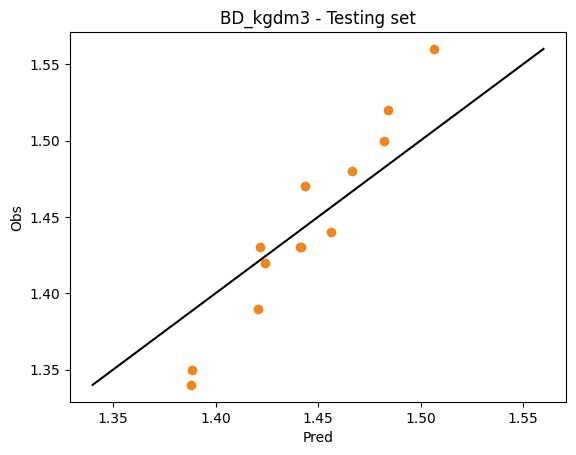

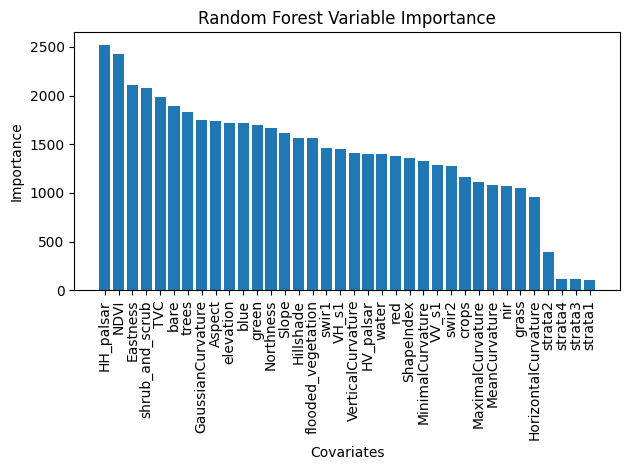

'Covariates:'

['elevation',
 'Aspect',
 'Eastness',
 'Northness',
 'Slope',
 'Hillshade',
 'MeanCurvature',
 'VerticalCurvature',
 'MaximalCurvature',
 'MinimalCurvature',
 'ShapeIndex',
 'GaussianCurvature',
 'HorizontalCurvature',
 'blue',
 'green',
 'red',
 'nir',
 'swir1',
 'swir2',
 'VH_s1',
 'VV_s1',
 'HH_palsar',
 'HV_palsar',
 'NDVI',
 'TVC',
 'strata1',
 'strata2',
 'strata3',
 'strata4',
 'water',
 'trees',
 'grass',
 'flooded_vegetation',
 'crops',
 'shrub_and_scrub',
 'bare']

Exporting grids as GeoJSON... to folder: Level1_ValleLeyda
FC size:  89 

FC attribute table (1st feature): 

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/Projects/SanJoseFarms/ValleLeyda/Senior_DSM/Level1_ValleLeyda/BD_kgdm3_2024_zonal_statistics.geojson
---------------------------------END-------------------------------------------
SOIL_PROPERTY: CE_dSm
SOIL_PROPERTY: CE_dSm, num_trees: 100, min_leaf_population: 1, variables_per_split: 36, RMSE: 0.09, MAPE: 34.82%, R²: 0.66, RPIQ: 0.91
SOIL_PROPERTY: CE_dSm, num_trees: 300, min_leaf_population: 1, variables_per_split: 36, RMSE: 0.09, MAPE: 37.57%, R²: 0.66, RPIQ: 0.87
SOIL_PROPERTY: CE_dSm, num_trees: 300, min_leaf_population: 1, variables_per_split: 12, RMSE: 0.09, MAPE: 38.89%, R²: 0.65, RPIQ: 0.84
SOIL_PROPERTY: CE_dSm, num_trees: 50, min_leaf_population: 1, variables_per_split: 36, RMSE: 0.1, MAPE: 36.03%, R²: 0.57, RPIQ: 0.84
SOIL_PROPERTY: CE_dSm, num_trees: 300, min_leaf

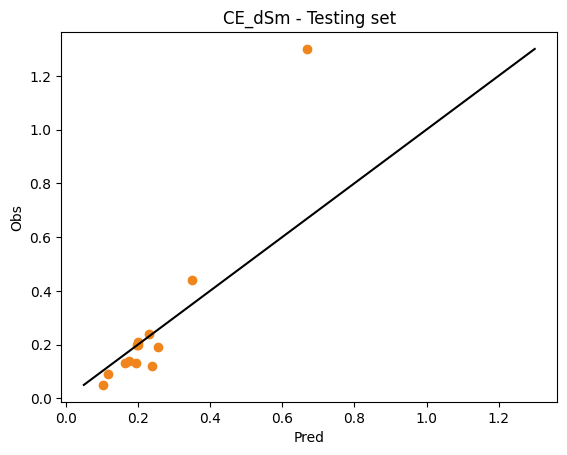

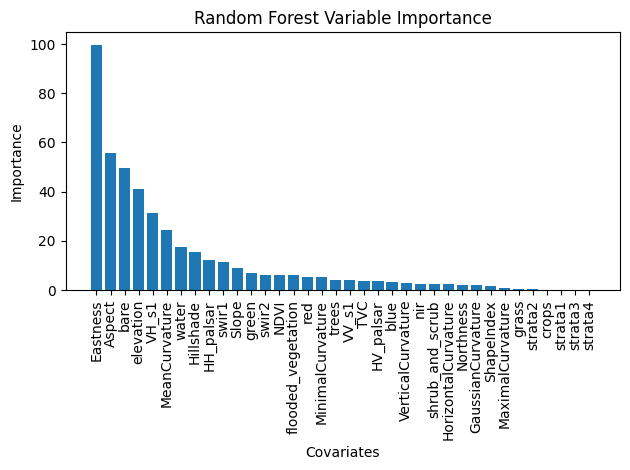

'Covariates:'

['elevation',
 'Aspect',
 'Eastness',
 'Northness',
 'Slope',
 'Hillshade',
 'MeanCurvature',
 'VerticalCurvature',
 'MaximalCurvature',
 'MinimalCurvature',
 'ShapeIndex',
 'GaussianCurvature',
 'HorizontalCurvature',
 'blue',
 'green',
 'red',
 'nir',
 'swir1',
 'swir2',
 'VH_s1',
 'VV_s1',
 'HH_palsar',
 'HV_palsar',
 'NDVI',
 'TVC',
 'strata1',
 'strata2',
 'strata3',
 'strata4',
 'water',
 'trees',
 'grass',
 'flooded_vegetation',
 'crops',
 'shrub_and_scrub',
 'bare']

Exporting grids as GeoJSON... to folder: Level1_ValleLeyda
FC size:  89 

FC attribute table (1st feature): 

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/Projects/SanJoseFarms/ValleLeyda/Senior_DSM/Level1_ValleLeyda/CE_dSm_2024_zonal_statistics.geojson
---------------------------------END-------------------------------------------
SOIL_PROPERTY: Clay_gkg
SOIL_PROPERTY: Clay_gkg, num_trees: 50, min_leaf_population: 1, variables_per_split: 36, RMSE: 16.18, MAPE: 5.19%, R²: 0.8, RPIQ: 4.94
SOIL_PROPERTY: Clay_gkg, num_trees: 300, min_leaf_population: 1, variables_per_split: 12, RMSE: 16.58, MAPE: 5.38%, R²: 0.8, RPIQ: 4.83
SOIL_PROPERTY: Clay_gkg, num_trees: 300, min_leaf_population: 1, variables_per_split: 36, RMSE: 16.68, MAPE: 5.4%, R²: 0.8, RPIQ: 4.8
SOIL_PROPERTY: Clay_gkg, num_trees: 50, min_leaf_population: 3, variables_per_split: 36, RMSE: 16.73, MAPE: 5.33%, R²: 0.78, RPIQ: 4.78
SOIL_PROPERTY: Clay_gkg, num_trees: 50, min_

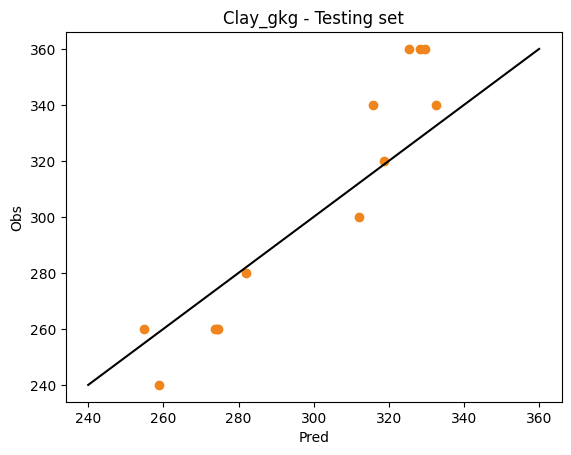

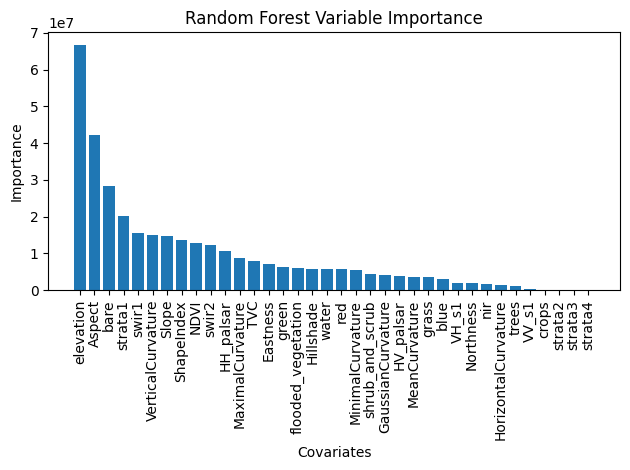

'Covariates:'

['elevation',
 'Aspect',
 'Eastness',
 'Northness',
 'Slope',
 'Hillshade',
 'MeanCurvature',
 'VerticalCurvature',
 'MaximalCurvature',
 'MinimalCurvature',
 'ShapeIndex',
 'GaussianCurvature',
 'HorizontalCurvature',
 'blue',
 'green',
 'red',
 'nir',
 'swir1',
 'swir2',
 'VH_s1',
 'VV_s1',
 'HH_palsar',
 'HV_palsar',
 'NDVI',
 'TVC',
 'strata1',
 'strata2',
 'strata3',
 'strata4',
 'water',
 'trees',
 'grass',
 'flooded_vegetation',
 'crops',
 'shrub_and_scrub',
 'bare']

Exporting grids as GeoJSON... to folder: Level1_ValleLeyda
FC size:  89 

FC attribute table (1st feature): 

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/Projects/SanJoseFarms/ValleLeyda/Senior_DSM/Level1_ValleLeyda/Clay_gkg_2024_zonal_statistics.geojson
---------------------------------END-------------------------------------------
SOIL_PROPERTY: K_mgkg
SOIL_PROPERTY: K_mgkg, num_trees: 300, min_leaf_population: 1, variables_per_split: 36, RMSE: 29.7, MAPE: 13.61%, R²: 0.69, RPIQ: 2.16
SOIL_PROPERTY: K_mgkg, num_trees: 50, min_leaf_population: 1, variables_per_split: 36, RMSE: 29.84, MAPE: 14.51%, R²: 0.67, RPIQ: 2.14
SOIL_PROPERTY: K_mgkg, num_trees: 300, min_leaf_population: 1, variables_per_split: 12, RMSE: 30.87, MAPE: 13.85%, R²: 0.68, RPIQ: 2.07
SOIL_PROPERTY: K_mgkg, num_trees: 300, min_leaf_population: 1, variables_per_split: 6, RMSE: 31.36, MAPE: 14.26%, R²: 0.66, RPIQ: 2.04
SOIL_PROPERTY: K_mgkg, num_trees: 100, min_l

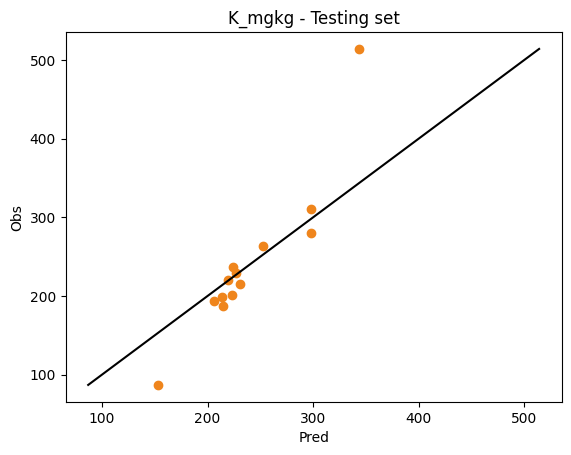

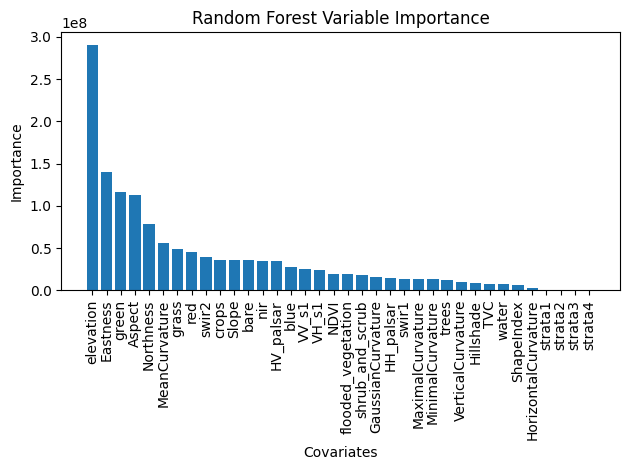

'Covariates:'

['elevation',
 'Aspect',
 'Eastness',
 'Northness',
 'Slope',
 'Hillshade',
 'MeanCurvature',
 'VerticalCurvature',
 'MaximalCurvature',
 'MinimalCurvature',
 'ShapeIndex',
 'GaussianCurvature',
 'HorizontalCurvature',
 'blue',
 'green',
 'red',
 'nir',
 'swir1',
 'swir2',
 'VH_s1',
 'VV_s1',
 'HH_palsar',
 'HV_palsar',
 'NDVI',
 'TVC',
 'strata1',
 'strata2',
 'strata3',
 'strata4',
 'water',
 'trees',
 'grass',
 'flooded_vegetation',
 'crops',
 'shrub_and_scrub',
 'bare']

Exporting grids as GeoJSON... to folder: Level1_ValleLeyda
FC size:  89 

FC attribute table (1st feature): 

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/Projects/SanJoseFarms/ValleLeyda/Senior_DSM/Level1_ValleLeyda/K_mgkg_2024_zonal_statistics.geojson
---------------------------------END-------------------------------------------
SOIL_PROPERTY: N_mgkg
SOIL_PROPERTY: N_mgkg, num_trees: 100, min_leaf_population: 1, variables_per_split: 6, RMSE: 2.52, MAPE: 16.2%, R²: 0.65, RPIQ: 1.59
SOIL_PROPERTY: N_mgkg, num_trees: 100, min_leaf_population: 1, variables_per_split: 12, RMSE: 2.57, MAPE: 16.72%, R²: 0.65, RPIQ: 1.56
SOIL_PROPERTY: N_mgkg, num_trees: 300, min_leaf_population: 1, variables_per_split: 12, RMSE: 2.58, MAPE: 15.89%, R²: 0.64, RPIQ: 1.55
SOIL_PROPERTY: N_mgkg, num_trees: 50, min_leaf_population: 1, variables_per_split: 6, RMSE: 2.59, MAPE: 16.2%, R²: 0.63, RPIQ: 1.55
SOIL_PROPERTY: N_mgkg, num_trees: 300, min_leaf_popu

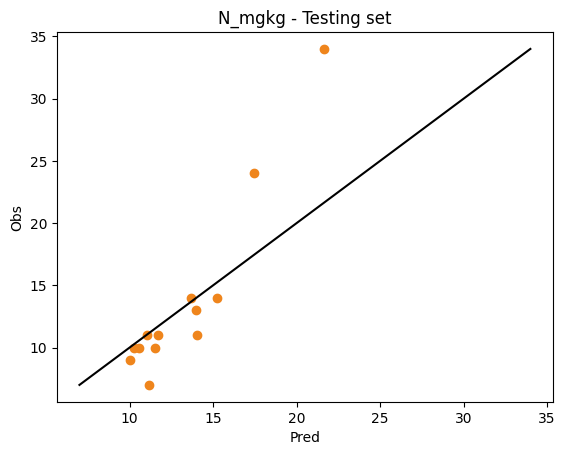

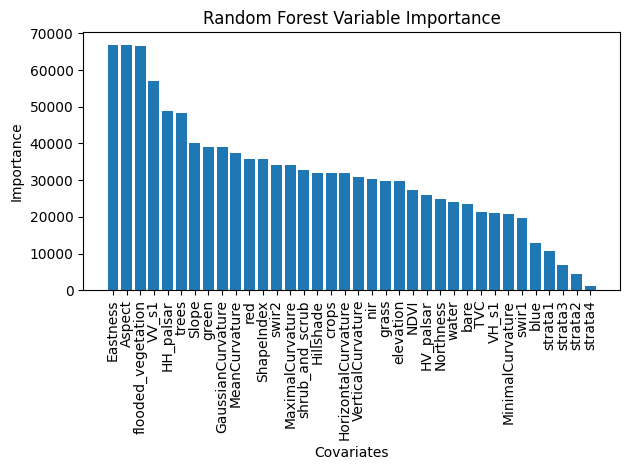

'Covariates:'

['elevation',
 'Aspect',
 'Eastness',
 'Northness',
 'Slope',
 'Hillshade',
 'MeanCurvature',
 'VerticalCurvature',
 'MaximalCurvature',
 'MinimalCurvature',
 'ShapeIndex',
 'GaussianCurvature',
 'HorizontalCurvature',
 'blue',
 'green',
 'red',
 'nir',
 'swir1',
 'swir2',
 'VH_s1',
 'VV_s1',
 'HH_palsar',
 'HV_palsar',
 'NDVI',
 'TVC',
 'strata1',
 'strata2',
 'strata3',
 'strata4',
 'water',
 'trees',
 'grass',
 'flooded_vegetation',
 'crops',
 'shrub_and_scrub',
 'bare']

Exporting grids as GeoJSON... to folder: Level1_ValleLeyda
FC size:  89 

FC attribute table (1st feature): 

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/Projects/SanJoseFarms/ValleLeyda/Senior_DSM/Level1_ValleLeyda/N_mgkg_2024_zonal_statistics.geojson
---------------------------------END-------------------------------------------
SOIL_PROPERTY: OM_gkg
SOIL_PROPERTY: OM_gkg, num_trees: 50, min_leaf_population: 1, variables_per_split: 12, RMSE: 1.65, MAPE: 9.22%, R²: 0.88, RPIQ: 2.43
SOIL_PROPERTY: OM_gkg, num_trees: 100, min_leaf_population: 1, variables_per_split: 12, RMSE: 1.66, MAPE: 9.1%, R²: 0.86, RPIQ: 2.4
SOIL_PROPERTY: OM_gkg, num_trees: 300, min_leaf_population: 1, variables_per_split: 12, RMSE: 1.73, MAPE: 9.71%, R²: 0.87, RPIQ: 2.31
SOIL_PROPERTY: OM_gkg, num_trees: 100, min_leaf_population: 1, variables_per_split: 36, RMSE: 1.74, MAPE: 9.21%, R²: 0.83, RPIQ: 2.3
SOIL_PROPERTY: OM_gkg, num_trees: 50, min_leaf_populati

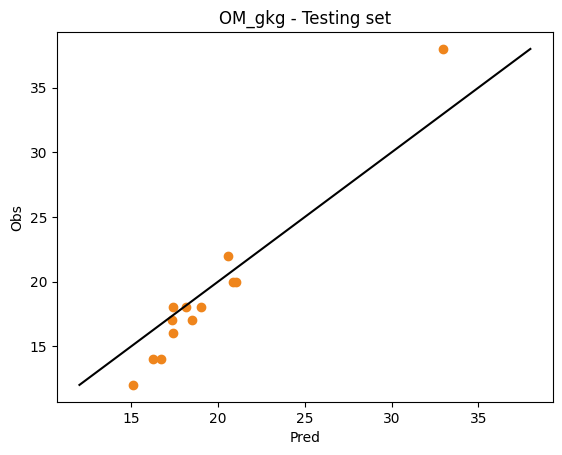

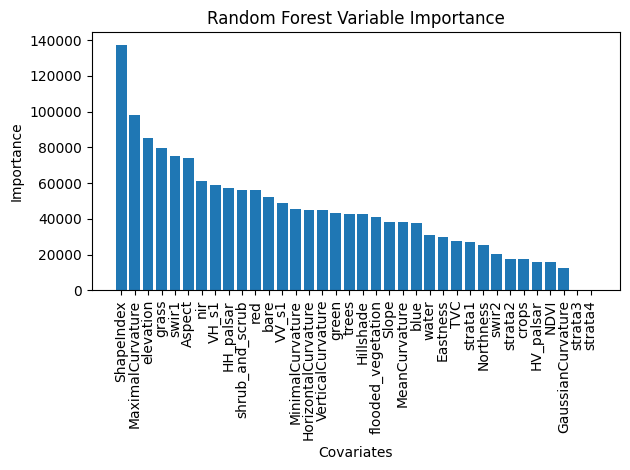

'Covariates:'

['elevation',
 'Aspect',
 'Eastness',
 'Northness',
 'Slope',
 'Hillshade',
 'MeanCurvature',
 'VerticalCurvature',
 'MaximalCurvature',
 'MinimalCurvature',
 'ShapeIndex',
 'GaussianCurvature',
 'HorizontalCurvature',
 'blue',
 'green',
 'red',
 'nir',
 'swir1',
 'swir2',
 'VH_s1',
 'VV_s1',
 'HH_palsar',
 'HV_palsar',
 'NDVI',
 'TVC',
 'strata1',
 'strata2',
 'strata3',
 'strata4',
 'water',
 'trees',
 'grass',
 'flooded_vegetation',
 'crops',
 'shrub_and_scrub',
 'bare']

Exporting grids as GeoJSON... to folder: Level1_ValleLeyda
FC size:  89 

FC attribute table (1st feature): 

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/Projects/SanJoseFarms/ValleLeyda/Senior_DSM/Level1_ValleLeyda/OM_gkg_2024_zonal_statistics.geojson
---------------------------------END-------------------------------------------
SOIL_PROPERTY: P_mgkg
SOIL_PROPERTY: P_mgkg, num_trees: 100, min_leaf_population: 1, variables_per_split: 36, RMSE: 4.04, MAPE: 23.36%, R²: 0.76, RPIQ: 3.47
SOIL_PROPERTY: P_mgkg, num_trees: 300, min_leaf_population: 1, variables_per_split: 36, RMSE: 4.04, MAPE: 23.18%, R²: 0.75, RPIQ: 3.46
SOIL_PROPERTY: P_mgkg, num_trees: 50, min_leaf_population: 1, variables_per_split: 12, RMSE: 4.14, MAPE: 25.77%, R²: 0.75, RPIQ: 3.38
SOIL_PROPERTY: P_mgkg, num_trees: 50, min_leaf_population: 1, variables_per_split: 36, RMSE: 4.19, MAPE: 25.56%, R²: 0.77, RPIQ: 3.34
SOIL_PROPERTY: P_mgkg, num_trees: 300, min_leaf_p

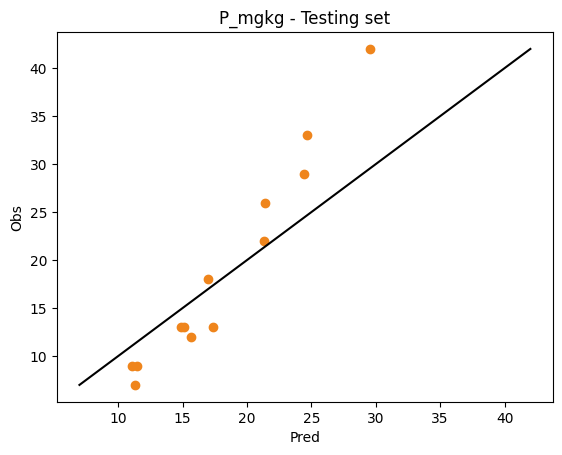

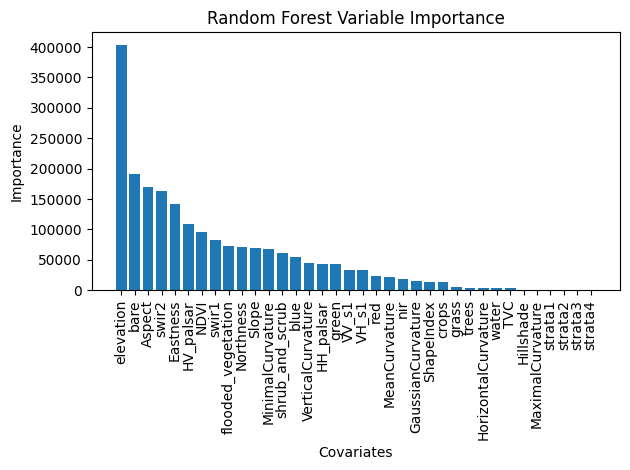

'Covariates:'

['elevation',
 'Aspect',
 'Eastness',
 'Northness',
 'Slope',
 'Hillshade',
 'MeanCurvature',
 'VerticalCurvature',
 'MaximalCurvature',
 'MinimalCurvature',
 'ShapeIndex',
 'GaussianCurvature',
 'HorizontalCurvature',
 'blue',
 'green',
 'red',
 'nir',
 'swir1',
 'swir2',
 'VH_s1',
 'VV_s1',
 'HH_palsar',
 'HV_palsar',
 'NDVI',
 'TVC',
 'strata1',
 'strata2',
 'strata3',
 'strata4',
 'water',
 'trees',
 'grass',
 'flooded_vegetation',
 'crops',
 'shrub_and_scrub',
 'bare']

Exporting grids as GeoJSON... to folder: Level1_ValleLeyda
FC size:  89 

FC attribute table (1st feature): 

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/Projects/SanJoseFarms/ValleLeyda/Senior_DSM/Level1_ValleLeyda/P_mgkg_2024_zonal_statistics.geojson
---------------------------------END-------------------------------------------
SOIL_PROPERTY: pH_water
SOIL_PROPERTY: pH_water, num_trees: 50, min_leaf_population: 1, variables_per_split: 12, RMSE: 0.28, MAPE: 4.82%, R²: 0.82, RPIQ: 4.71
SOIL_PROPERTY: pH_water, num_trees: 100, min_leaf_population: 1, variables_per_split: 12, RMSE: 0.28, MAPE: 4.9%, R²: 0.82, RPIQ: 4.61
SOIL_PROPERTY: pH_water, num_trees: 50, min_leaf_population: 1, variables_per_split: 36, RMSE: 0.3, MAPE: 5.25%, R²: 0.8, RPIQ: 4.35
SOIL_PROPERTY: pH_water, num_trees: 300, min_leaf_population: 1, variables_per_split: 12, RMSE: 0.3, MAPE: 5.29%, R²: 0.8, RPIQ: 4.3
SOIL_PROPERTY: pH_water, num_trees: 50, min_leaf_

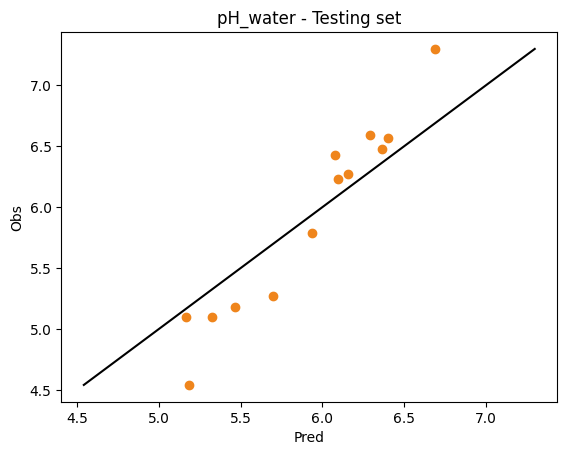

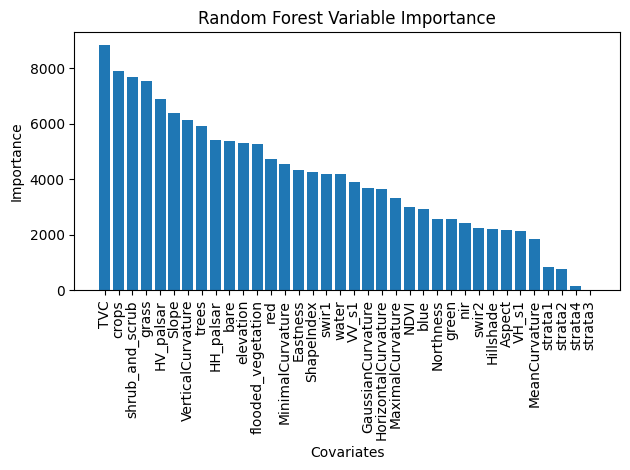

'Covariates:'

['elevation',
 'Aspect',
 'Eastness',
 'Northness',
 'Slope',
 'Hillshade',
 'MeanCurvature',
 'VerticalCurvature',
 'MaximalCurvature',
 'MinimalCurvature',
 'ShapeIndex',
 'GaussianCurvature',
 'HorizontalCurvature',
 'blue',
 'green',
 'red',
 'nir',
 'swir1',
 'swir2',
 'VH_s1',
 'VV_s1',
 'HH_palsar',
 'HV_palsar',
 'NDVI',
 'TVC',
 'strata1',
 'strata2',
 'strata3',
 'strata4',
 'water',
 'trees',
 'grass',
 'flooded_vegetation',
 'crops',
 'shrub_and_scrub',
 'bare']

Exporting grids as GeoJSON... to folder: Level1_ValleLeyda
FC size:  89 

FC attribute table (1st feature): 

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/Projects/SanJoseFarms/ValleLeyda/Senior_DSM/Level1_ValleLeyda/pH_water_2024_zonal_statistics.geojson
---------------------------------END-------------------------------------------
SOIL_PROPERTY: Sand_gkg
SOIL_PROPERTY: Sand_gkg, num_trees: 300, min_leaf_population: 1, variables_per_split: 12, RMSE: 18.83, MAPE: 5.23%, R²: 0.83, RPIQ: 5.31
SOIL_PROPERTY: Sand_gkg, num_trees: 100, min_leaf_population: 1, variables_per_split: 12, RMSE: 19.16, MAPE: 5.15%, R²: 0.84, RPIQ: 5.22
SOIL_PROPERTY: Sand_gkg, num_trees: 100, min_leaf_population: 1, variables_per_split: 36, RMSE: 19.72, MAPE: 5.28%, R²: 0.82, RPIQ: 5.07
SOIL_PROPERTY: Sand_gkg, num_trees: 50, min_leaf_population: 1, variables_per_split: 12, RMSE: 20.04, MAPE: 5.38%, R²: 0.84, RPIQ: 4.99
SOIL_PROPERTY: Sand_gkg, num_trees: 

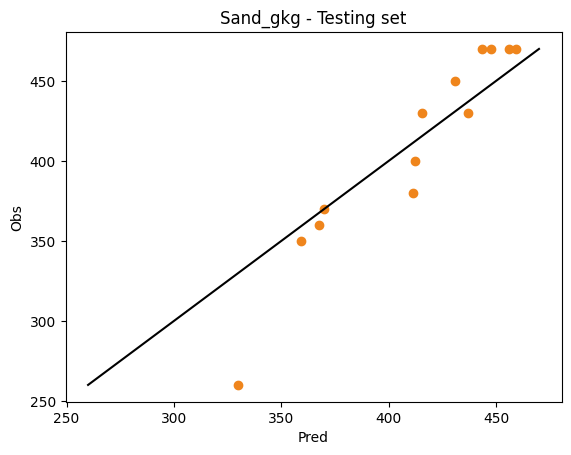

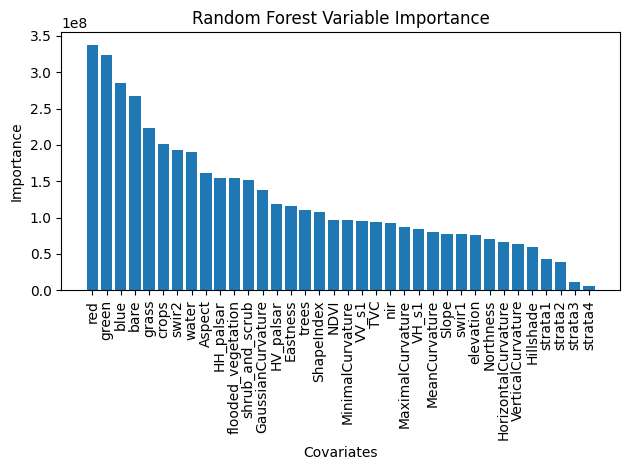

'Covariates:'

['elevation',
 'Aspect',
 'Eastness',
 'Northness',
 'Slope',
 'Hillshade',
 'MeanCurvature',
 'VerticalCurvature',
 'MaximalCurvature',
 'MinimalCurvature',
 'ShapeIndex',
 'GaussianCurvature',
 'HorizontalCurvature',
 'blue',
 'green',
 'red',
 'nir',
 'swir1',
 'swir2',
 'VH_s1',
 'VV_s1',
 'HH_palsar',
 'HV_palsar',
 'NDVI',
 'TVC',
 'strata1',
 'strata2',
 'strata3',
 'strata4',
 'water',
 'trees',
 'grass',
 'flooded_vegetation',
 'crops',
 'shrub_and_scrub',
 'bare']

Exporting grids as GeoJSON... to folder: Level1_ValleLeyda
FC size:  89 

FC attribute table (1st feature): 

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/Projects/SanJoseFarms/ValleLeyda/Senior_DSM/Level1_ValleLeyda/Sand_gkg_2024_zonal_statistics.geojson
---------------------------------END-------------------------------------------
SOIL_PROPERTY: Silt_gkg
SOIL_PROPERTY: Silt_gkg, num_trees: 300, min_leaf_population: 1, variables_per_split: 6, RMSE: 15.1, MAPE: 5.66%, R²: 0.73, RPIQ: 1.32
SOIL_PROPERTY: Silt_gkg, num_trees: 50, min_leaf_population: 1, variables_per_split: 6, RMSE: 15.21, MAPE: 5.66%, R²: 0.68, RPIQ: 1.31
SOIL_PROPERTY: Silt_gkg, num_trees: 100, min_leaf_population: 1, variables_per_split: 6, RMSE: 15.5, MAPE: 5.83%, R²: 0.69, RPIQ: 1.29
SOIL_PROPERTY: Silt_gkg, num_trees: 300, min_leaf_population: 1, variables_per_split: 12, RMSE: 15.81, MAPE: 5.9%, R²: 0.72, RPIQ: 1.26
SOIL_PROPERTY: Silt_gkg, num_trees: 300, m

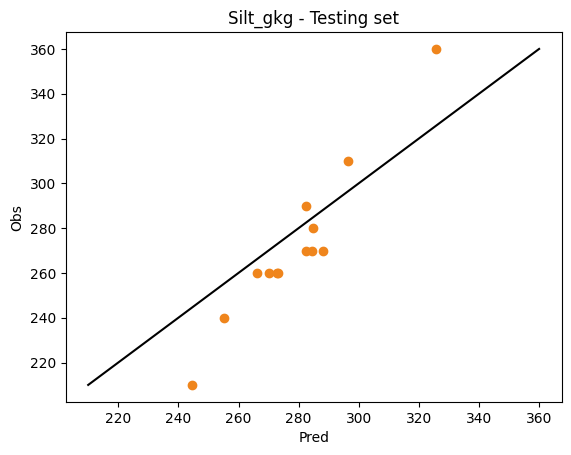

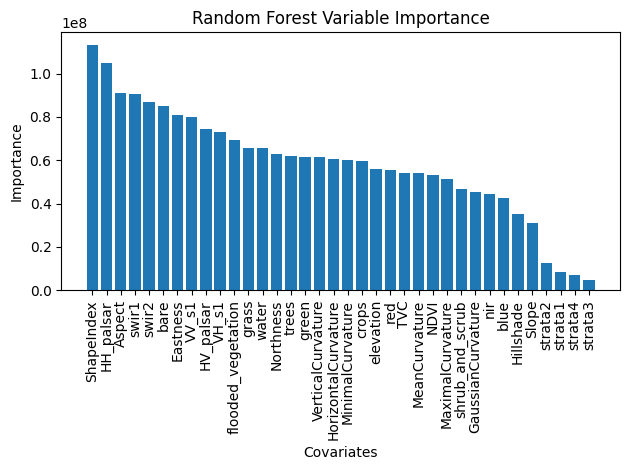

'Covariates:'

['elevation',
 'Aspect',
 'Eastness',
 'Northness',
 'Slope',
 'Hillshade',
 'MeanCurvature',
 'VerticalCurvature',
 'MaximalCurvature',
 'MinimalCurvature',
 'ShapeIndex',
 'GaussianCurvature',
 'HorizontalCurvature',
 'blue',
 'green',
 'red',
 'nir',
 'swir1',
 'swir2',
 'VH_s1',
 'VV_s1',
 'HH_palsar',
 'HV_palsar',
 'NDVI',
 'TVC',
 'strata1',
 'strata2',
 'strata3',
 'strata4',
 'water',
 'trees',
 'grass',
 'flooded_vegetation',
 'crops',
 'shrub_and_scrub',
 'bare']

Exporting grids as GeoJSON... to folder: Level1_ValleLeyda
FC size:  89 

FC attribute table (1st feature): 

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/Projects/SanJoseFarms/ValleLeyda/Senior_DSM/Level1_ValleLeyda/Silt_gkg_2024_zonal_statistics.geojson
---------------------------------END-------------------------------------------


In [ ]:
# Import necessary libraries
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# Extract covariates
extracted = covariates_reproj_30m.sampleRegions(collection=data_for_mapping, scale=30)
time.sleep(2)

# Generate training and validation set
extracted_random = extracted.randomColumn("random", seed=42)
training = extracted_random.filter(ee.Filter.lt("random", 1))
validation = extracted_random.filter(ee.Filter.gte("random", 0.5))
time.sleep(2)

# Hyperparameter ranges
num_trees_range = [50, 100, 300]
min_leaf_population_range = [1, 3]
sqrt_var = ee.Number(len(bands)).sqrt().round()
variables_per_split_range = [sqrt_var, sqrt_var.multiply(2), ee.Number(len(bands))]

# Loop through each soil property in rename_dict.values()
for SOIL_PROPERTY in SOIL_PROPERTIES:
    print(f"SOIL_PROPERTY: {SOIL_PROPERTY}")
    time.sleep(2)

    # Function to train and evaluate the model
    def train_and_evaluate(num_trees, min_leaf_population, variables_per_split):
        # Train model
        rf = (
            ee.Classifier.smileRandomForest(
                numberOfTrees=num_trees,
                variablesPerSplit=variables_per_split,
                minLeafPopulation=min_leaf_population,
                bagFraction=1,
                maxNodes=None,
                seed=42,
            )
            .setOutputMode("REGRESSION")
            .train(training, SOIL_PROPERTY, bands)
        )
        time.sleep(2)

        # Validation
        val = validation.classify(rf, "pred_" + SOIL_PROPERTY)
        val_extracted = val.reduceColumns(ee.Reducer.toList(2), [SOIL_PROPERTY, "pred_" + SOIL_PROPERTY]).get("list")
        val_list = ee.Array(val_extracted).getInfo()
        time.sleep(2)

        obs = [v[0] for v in val_list]
        pred = [v[1] for v in val_list]

        # Calculate metrics
        rmse = mean_absolute_error(obs, pred)
        mape = mean_absolute_percentage_error(obs, pred) * 100
        r2 = r2_score(obs, pred)

        obs_list = ee.List(obs)
        q1 = obs_list.reduce(ee.Reducer.percentile([25])).getInfo()
        q3 = obs_list.reduce(ee.Reducer.percentile([75])).getInfo()
        iqr = ee.Number(q3).subtract(ee.Number(q1))
        rpiq = iqr.divide(rmse).getInfo()

        return {'num_trees': num_trees, 'min_leaf_population': min_leaf_population, 'variables_per_split': variables_per_split.getInfo(), 'rmse': rmse, 'mape': mape, 'r2': r2, 'rpiq': rpiq, 'classifier': rf}

    time.sleep(2)

    # Perform grid search
    results = []
    classifiers = []
    for num_trees in num_trees_range:
        for min_leaf_population in min_leaf_population_range:
            for variables_per_split in variables_per_split_range:
                result = train_and_evaluate(num_trees, min_leaf_population, variables_per_split)
                results.append(result)
                classifiers.append(result['classifier'])

    # Sort results by RMSE
    sorted_results = sorted(results, key=lambda x: x['rmse'])

    # Print sorted results
    for result in sorted_results:
        print(f"SOIL_PROPERTY: {SOIL_PROPERTY}, num_trees: {result['num_trees']}, min_leaf_population: {result['min_leaf_population']}, variables_per_split: {result['variables_per_split']}, RMSE: {round(result['rmse'], 2)}, MAPE: {round(result['mape'], 2)}%, R²: {round(result['r2'], 2)}, RPIQ: {round(result['rpiq'], 2)}")

    # Find the best model with the lowest RMSE
    best_model = sorted_results[0]
    rf_optimal = best_model['classifier']

    # Print best model parameters and performance
    best_model_params = f"Best model parameters  --> SOIL_PROPERTY: {SOIL_PROPERTY}, num_trees: {best_model['num_trees']}, min_leaf_population: {best_model['min_leaf_population']}, variables_per_split: {best_model['variables_per_split']}\n"
    best_model_performance = f"Best model performance --> RMSE: {round(best_model['rmse'], 2)}, MAPE: {round(best_model['mape'], 2)}%, R²: {round(best_model['r2'], 2)}, RPIQ: {round(best_model['rpiq'], 2)}\n"

    print(best_model_params)
    print(best_model_performance)

    # Save parameters and performance to a text file
    with open(f"{out_path}/{SOIL_PROPERTY}_{year}_model_metrics.txt", "w") as file:
        file.write(best_model_params)
        file.write(best_model_performance)

    # Validation
    val = validation.classify(rf_optimal, "pred_" + SOIL_PROPERTY)
    val_extracted = val.reduceColumns(ee.Reducer.toList(2), [SOIL_PROPERTY, "pred_" + SOIL_PROPERTY]).get("list")
    val_list = ee.Array(val_extracted).getInfo()
    time.sleep(2)

    obs = [v[0] for v in val_list]
    pred = [v[1] for v in val_list]

    # Convert lists to ee.Array
    obs_array = ee.Array(obs)
    pred_array = ee.Array(pred)
    time.sleep(2)

    # Scatterplot Obs X Pred
    plt.scatter(pred, obs, color="#EF851C")
    plt.plot([min(obs), max(obs)], [min(obs), max(obs)], color="black")
    plt.title(SOIL_PROPERTY + " - Testing set")
    plt.xlabel("Pred")
    plt.ylabel("Obs")
    plt.show()

    # Variable Importance
    dict_rf = rf_optimal.explain().getInfo()
    importance = dict_rf["importance"]
    importance_sorted = dict(
        sorted(importance.items(), key=lambda item: item[1], reverse=True)
    )

    plt.bar(importance_sorted.keys(), importance_sorted.values())
    plt.title("Random Forest Variable Importance")
    plt.xlabel("Covariates")
    plt.ylabel("Importance")
    plt.xticks(rotation=90)

    plt.tight_layout()

    # Define the path to save the plot in Google Drive
    plt.savefig(f"{out_path}/{SOIL_PROPERTY}_{year}_variable_importance.png")
    plt.show()

    # Function to reproject image
    reproject_image_10m = lambda image: image.reproject(crs="EPSG:4326", scale=10)

    # Map the reproject function over the ImageCollection (reproject the image to match the grid of polygons)
    covariates_reproj_10m = ee.ImageCollection(covariates).map(reproject_image_10m)
    covariates_reproj_10m = covariates_reproj_10m.toBands()

    bands = covariates_reproj_10m.bandNames()
    bands = [s.split("_",1)[-1] for s in bands.getInfo()] # remove first two characters
    display("Covariates:", bands)

    covariates_reproj_10m = covariates_reproj_10m.rename(bands)
    time.sleep(2)

    # Generate prediction map
    pred_map_10m = covariates_reproj_10m.classify(rf_optimal, "pred_" + SOIL_PROPERTY).reproject(crs="EPSG:4326", scale=10)  # .toInt16()
    time.sleep(2)
    # pred_map_30m = covariates_reproj_30m.classify(rf_optimal, "pred_" + SOIL_PROPERTY).reproject(crs="EPSG:4326", scale=30)  # .toInt16()
    # time.sleep(2)

    # Create a covering grid
    covering_grid = fieldBounds.geometry().coveringGrid("EPSG:4326", 10)

    # Get pixel values for each grid (polygon)
    gridWithValues = pred_map_10m.multiply(100).reduceRegions(
        collection=covering_grid,
        reducer=ee.Reducer.first().setOutputs([SOIL_PROPERTY]),
        scale=10,
        crs='EPSG:4326',
        tileScale=16
    )
    time.sleep(2)

    # Get grids just within cuarteles
    gridWithValues = gridWithValues.map(lambda f: f.intersection(fieldBounds.geometry(), 1, "EPSG:4326"))

    # Function to round predicted values and handle null values (pixels masked by clouds in vegetation index)
    def round_predicted_values(feature):
        value = ee.Algorithms.If(
            ee.Number(feature.get(SOIL_PROPERTY)),
            ee.Number(feature.get(SOIL_PROPERTY)).divide(100),
            # ee.Number(feature.get(SOIL_PROPERTY)).multiply(5).round().divide(5),
            ee.Number(-99999)
        )
        return feature.set(SOIL_PROPERTY, value)

    gridWithValues = gridWithValues.map(round_predicted_values)

    # Remove features with values equal to -99999
    gridWithValues = gridWithValues.filter(ee.Filter.neq(SOIL_PROPERTY, -99999))

    # Map a function to add a property 'geo_type' to each feature indicating its geometry type
    def add_geometry_type(feature):
        return feature.set("geo_type", ee.String(feature.geometry().type()))

    # Map the function over the collection
    gridWithValues = gridWithValues.map(add_geometry_type)

    # Filter features with geometry type 'Polygon'
    gridWithValues = gridWithValues.filter(
        ee.Filter.inList("geo_type", ["Rectangle", "Polygon", "MultiPolygon"])
    )

    # Select column SOIL_PROPERTY
    gridWithValues = gridWithValues.map(lambda f: f.select([SOIL_PROPERTY]))
    time.sleep(2)

    # Export the sampled regions to Google Drive as GeoJSON
    export_task = ee.batch.Export.table.toDrive(
        collection=gridWithValues,
        description=f"{SOIL_PROPERTY}_{year}_map_10m",
        folder=folder_vector_specific,
        fileNamePrefix=f"{SOIL_PROPERTY}_{year}_map_10m",
        fileFormat="GeoJSON"
    )

    # Start the GeoJSON export task
    export_task.start()

    print(f"Exporting grids as GeoJSON... to folder: {folder_vector_specific}")
    time.sleep(2)

    # Import farm plot boundaries (shapefiles)
    fc = ee.FeatureCollection(f'projects/ee-raul/assets/Projects/{file_name}')
    time.sleep(2)

    print('FC size: ', fc.size().getInfo(), '\n')

    # Display the table of attributes for one feature/polygon
    print('FC attribute table (1st feature): \n')
    dic = fc.limit(1).getInfo()['features'][0]['properties']
    pd.DataFrame(dic.values(), dic.keys()).T

    # Select an attribute name (column) that contains the ID of polygons
    ID = 'Name'
    fc_to_reduction = fc.select([ID], ["Name"])

    # Zonal statistics parameters
    parameters = {
        'in_value_raster': pred_map_10m,
        'statistics_type': 'MEAN',
        'scale': float(10.0),  # a high scale avoid missing values
        'tile_scale': 16.0,
        'return_fc': False,
        'timeout': 3000,
    }
    time.sleep(2)

    geemap.zonal_statistics(in_zone_vector=fc_to_reduction, out_file_path=f"{out_path}/{SOIL_PROPERTY}_{year}_zonal_statistics.geojson", **parameters)
    print("---------------------------------END-------------------------------------------")

Check task status in GEE...